## Capstone Data Wrangling with Sales Activity
### by Nicholas Sewitz

In this project I connect Artsy's redshift to pull in activity level data. We are pulling from tables, tasks (sales activity), site_landings, emails (marketing activity), and opportunities. The first 3 make up our features, and the last is where we get the output (and some demographic data). The goal of the analysis is to predict whether or not an opportunity will closed won, and what factors weigh most heavily in that decision. 

We have to do some wrangling to clean up and combine the features and outputs. For the activity features we create counts of the activities that happened before the opp closed. For the demographic features we create dummy variables.

After we wrangle we do a correlation analysis and then dive into a few different classification models. By


In [19]:
import sys, os
sys.path.append(os.environ['minotaur'])

import seaborn as sns
import sklearn
from sklearn.model_selection import cross_val_score


import yaml

%matplotlib inline
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import patsy
import statsmodels.api as sm

from pylab import rcParams
rcParams['figure.figsize'] = 14,3

from dbs import redshift
redshift.connect()

from __future__ import division

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, scale
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline



In [20]:
tasks = redshift.execute("""
SELECT t.activity_date,
       COALESCE(c.email,l.email) AS email,
       COALESCE(c.account_id,l.id) AS company_id,
       'sales' as source_table,
       t.type as activity_type,
       t.call_c as call_type
FROM segment_salesforce.tasks t
  LEFT JOIN segment_salesforce.contacts c
         ON t.who_id = c.id
        AND NOT c.is_deleted
  LEFT JOIN segment_salesforce.leads l
         ON t.who_id = l.id
        AND NOT l.is_deleted
WHERE NOT t.is_deleted AND (t.type = 'Email' OR t.type = 'Call')
""")
emails = redshift.execute("""
SELECT e.activity_date,
       p.email,
       p.company_id,
       'marketing' as source_table,
       'marketing_email' as activity_type,
       NULL as call_type
FROM marketo.email_delivers e
  INNER JOIN analytics.salesforce_patrons p ON e.lead_id = p.marketo_id
""")
opportunities = redshift.execute("""
SELECT o.id,
       o.account_id,
       o.stage_name,
       o.amount,
       o.created_date,
       o.close_date,
       o.abbreviated_channel_c,
       a.gallery_tier_c,
       a.sub_region_c
       FROM segment_salesforce.opportunities o 
           LEFT JOIN segment_salesforce.accounts a on o.account_id = a.id and not a.is_deleted
WHERE NOT o.is_deleted
AND   o.type = 'Activation'
AND (o.stage_name = 'Closed Won' OR o.stage_name = 'Closed Lost')
""")
site_landings = redshift.execute("""
SELECT sl.sent_at as activity_date,
       meam.email,
       sp.company_id,
       'site' as source_table,
       'site_visit' as activity_type,
       NULL as call_type
FROM analytics.site_landings sl
  INNER JOIN analytics.marketo_email_alias_mapping meam ON sl.looker_visitor_id = meam.looker_visitor_id
  INNER JOIN analytics.salesforce_patrons sp on meam.email = sp.email""")

In [21]:
# combine activity data into one dataframe

con = pd.concat([tasks,emails,site_landings],axis=0)

In [22]:
# clean up

con.activity_type = con.activity_type.astype(str)
con.activity_type = con['activity_type'].apply(str.lower)
con.activity_type.unique()

array(['email', 'call', 'marketing_email', 'site_visit'], dtype=object)

In [23]:
con.call_type.unique()

array([None, 'No Answer', 'Connected', 'Left Voicemail', 'Busy',
       'Wrong Number', 'Not in Service', 'Rejected'], dtype=object)

In [24]:
# create call_connect column

con.loc[con['call_type'] == 'Connected', 'activity_type'] = 'call_connect'
con.activity_type.unique()        

array(['email', 'call', 'call_connect', 'marketing_email', 'site_visit'], dtype=object)

In [25]:
opps = pd.merge(con,opportunities,left_on='company_id',right_on='account_id',how='left')

In [26]:
opps['activity_date'] = pd.to_datetime(opps['activity_date'])
opps['created_date'] = pd.to_datetime(opps['created_date'])
opps['close_date'] = pd.to_datetime(opps['close_date'])

In [27]:
# attach activity data to opportunities

opps['days'] = (opps.created_date - opps.activity_date).astype('timedelta64[D]')
opps['has_opp'] = ((opps.days <= 90) & (opps.days >= 0))
opps['has_inbound'] = opps.abbreviated_channel_c == 'Inbound'
opps['has_outbound'] = opps.abbreviated_channel_c == 'Outbound'
opps['has_inbound'] = opps['has_inbound'].astype(int)
opps['has_outbound'] = opps['has_outbound'].astype(int)

In [28]:
hops = opps[opps.has_opp == True].copy()
hops['company_opp'] = hops.company_id.map(str) + hops.id.map(str)

In [29]:
# dummy variables for region

sub = hops[['company_opp','sub_region_c']].copy()
sub = sub.set_index('company_opp',drop=True)
sub = sub[~sub.index.duplicated(keep='last')]
sub = pd.get_dummies(sub,prefix='region')

In [30]:
# dummy variables for gallery tier

tier = hops[['company_opp','gallery_tier_c']].copy()
tier = tier.set_index('company_opp',drop=True)
tier = tier[~tier.index.duplicated(keep='last')]
tier = pd.get_dummies(tier,prefix='tier')

In [31]:
df = []
for company_opp in company_opps:
    d = dict(hops[hops.company_opp == company_opp].activity_type.value_counts())
    d['id'] = company_opp
    df += [d]
df = pd.DataFrame(df)


In [32]:
df = df.fillna(0)
df = df.set_index(['id'],drop=True)

In [33]:
# create boolean won/lost to predict on

won = hops.set_index('company_opp',drop=True)
won['is_won'] = won.stage_name == 'Closed Won'

In [34]:
won = won[['is_won']].copy()
won = won[~won.index.duplicated(keep='last')]
won.index.size

8846

In [35]:
chan = hops[['company_opp','has_inbound','has_outbound']].copy()
chan = chan.set_index('company_opp',drop=True)

In [60]:
# create final dataframe

final = df.join(won)
final = final.join(sub)
final = final.join(tier)
final = final.join(chan)
final = final[~final.index.duplicated(keep='last')]
final = final[final.is_won.notnull()].fillna(0)
print(final.shape)

(8844, 52)


In [61]:
final.to_csv('final.csv')

### Begin Modeling

In [62]:
# final is not normalized.
X = final.copy()
X.head()

y = X['is_won'].copy()
del X['is_won']


### Logistic Regression Exploration

In [64]:
# Setup the pipeline
steps = [('scaler', StandardScaler()),
        ('dec', LogisticRegression())]
        
# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the pipeline to the training set: knn_scaled
log_scaled = pipeline.fit(X_train, y_train)

# Instantiate and fit a Log classifier to the unscaled data
log_unscaled = LogisticRegression().fit(X_train, y_train)

# Compute and print metrics
print('Accuracy with Scaling: {}'.format(log_scaled.score(X_test, y_test)))
print('Accuracy without Scaling: {}'.format(log_unscaled.score(X_test, y_test)))

Accuracy with Scaling: 0.7840994724943482
Accuracy without Scaling: 0.7844762622456669


In [65]:
#Scale X
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X),columns = X.columns)

# Create the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
weights = {}
param_grid = {'C': c_space, 
              'penalty': ['l1', 'l2']
              #'class_weight': ['balanced']
             }

# Instantiate the logistic regression classifier: logreg
logreg = LogisticRegression()

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,test_size=.3,random_state=42)

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg,param_grid,cv=5)

# Fit it to the training data
logreg_cv.fit(X_train,y_train)

# Print the optimal parameters and best score
print("Tuned Logistic Regression Parameter: {}".format(logreg_cv.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(logreg_cv.best_score_))


Tuned Logistic Regression Parameter: {'C': 8.4834289824407252e-05, 'penalty': 'l2'}
Tuned Logistic Regression Accuracy: 0.7804523424878836


In [66]:
# looks like logistic regression is giving us the best accuracy and coverage across targets
#

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)


# Create the classifier: Logistic Regression
logreg = LogisticRegression(C= 3.7275937203149381, penalty= 'l2')

# Fit the classifier to the training data
logreg.fit(X_train,y_train)

# Predict the labels of the test set: y_pred
y_pred = logreg.predict(X_test)


print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[2020   26]
 [ 544   64]]
             precision    recall  f1-score   support

      False       0.79      0.99      0.88      2046
       True       0.71      0.11      0.18       608

avg / total       0.77      0.79      0.72      2654



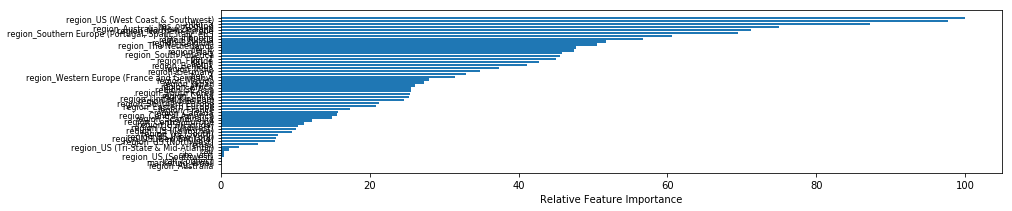

In [91]:
# Feature Importance,  how do I make the graph bigger???

feature_importance = abs(logreg.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5


featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.figure(figsize=(500,500))
plt.show()

#### Decision Tree Classifier

In [78]:
# Setup the pipeline
steps = [('scaler', StandardScaler()),
        ('dec', DecisionTreeClassifier())]
        
# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the pipeline to the training set: knn_scaled
dec_scaled = pipeline.fit(X_train, y_train)

# Instantiate and fit a k-NN classifier to the unscaled data
dec_unscaled = DecisionTreeClassifier().fit(X_train, y_train)

# Compute and print metrics
print('Accuracy with Scaling: {}'.format(dec_scaled.score(X_test, y_test)))
print('Accuracy without Scaling: {}'.format(dec_unscaled.score(X_test, y_test)))

Accuracy with Scaling: 0.7136397889977393
Accuracy without Scaling: 0.7143933685003768


In [83]:
# Setup the hyperparameter grid
param_dist = {"max_depth": [3,5,10,20,50],
              "max_features": randint(1, 50),
              "min_samples_leaf": randint(1, 50),
              "criterion": ["gini", "entropy"],
              "class_weight": ['balanced']}

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = RandomizedSearchCV(tree, param_dist, cv=5)

# Fit it to the data
tree_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'max_features': 13, 'min_samples_leaf': 13}
Best score is 0.612053369516056


In [85]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=42)


# Create the classifier: tree
tree = DecisionTreeClassifier(criterion= 'gini', max_depth= 10, max_features= 13, min_samples_leaf= 13, class_weight= 'balanced')

# Fit the classifier to the training data
tree.fit(X_train,y_train)

# Predict the labels of the test set: y_pred
y_pred = tree.predict(X_test)


print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1950  786]
 [ 408  394]]
             precision    recall  f1-score   support

      False       0.83      0.71      0.77      2736
       True       0.33      0.49      0.40       802

avg / total       0.72      0.66      0.68      3538



#### Random Forest Classifier

In [87]:
# Setup the pipeline
steps = [('scaler', StandardScaler()),
        ('dec', RandomForestClassifier())]
        
# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the pipeline to the training set: knn_scaled
dec_scaled = pipeline.fit(X_train, y_train)

# Instantiate and fit a k-NN classifier to the unscaled data
dec_unscaled = RandomForestClassifier().fit(X_train, y_train)

# Compute and print metrics
print('Accuracy with Scaling: {}'.format(dec_scaled.score(X_test, y_test)))
print('Accuracy without Scaling: {}'.format(dec_unscaled.score(X_test, y_test)))

Accuracy with Scaling: 0.7418990203466466
Accuracy without Scaling: 0.7486812358703844


In [ ]:
# Setup the hyperparameter grid
param_dist = {"n_estimators": [100,200,500,700,1000],
              "max_features": ['auto', 'sqrt', 'log2'],
              "n_jobs": [-1,1,5,10],
              "class_weight": ['balanced']}

# Instantiate a Decision Tree classifier: tree
forest = RandomForestClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
forest_cv = GridSearchCV(forest, param_dist, cv=5)

# Fit it to the data
forest_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(forest_cv.best_params_))
print("Best score is {}".format(forest_cv.best_score_))

In [89]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=42)


# Create the classifier: tree
forest = RandomForestClassifier(n_estimators=1000, max_features='log2', class_weight="balanced", n_jobs= -1)

# Fit the classifier to the training data
forest.fit(X_train,y_train)

# Predict the labels of the test set: y_pred
y_pred = forest.predict(X_test)


print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[2437  299]
 [ 641  161]]
             precision    recall  f1-score   support

      False       0.79      0.89      0.84      2736
       True       0.35      0.20      0.26       802

avg / total       0.69      0.73      0.71      3538

